**Music Genre Classification using CNN**

In [ ]:
# Arrays
import numpy as np

# Everything audio file related
import librosa, librosa.display

# Visualization
import matplotlib.pyplot as plt

# For file management
import os

# ceil() function
import math

In [ ]:
# Function for splitting dataset
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

import tensorflow as tf

from tensorflow.keras import datasets, layers, models


In [ ]:
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras.layers import Convolution2D, MaxPooling2D 
from keras.utils import np_utils

In [ ]:
# GTZAN Dataset located in Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Step 1: Create MFCC files from the audio files.**



Variables related to audio files and MFCC parameters.

In [ ]:
dataPath = "/content/drive/MyDrive/genres_original"
sampleRate = 22050 # (Hz)
trackLength = 30 # (second)
numMFCC = 20    # Number of MFCC for each audio file segment.
nFFT = 2048     # Length of the FFT window
hopLength = 512 # Number of samples between each frame.
segments = 13   # Number of segments for dividing audio file.
samplePerSeg = int(661500 / segments)
mfccPerSeg = math.ceil(samplePerSeg / hopLength)

We save and load the MFCC files in a numpy array for further processing.

In [ ]:
# Dict for converting non-numeric feature into a numeric feature.
genreToNum = {
      "blues":0,
      "classical":1,
      "country":2,
      "disco":3,
      "hiphop":4,
      "jazz" :5,
      "metal" :6,
      "pop" :7,
      "reggae" :8,
      "rock" :9
  }

# Initialize output variables
XasList = []
y = np.array([]);

# Go through genre files
for subdir, dirs, files in os.walk(dataPath):

      # Go through audio files
      for file in files:

          # Get the genre name from current folder.
          currentGenre = subdir.split("/")[-1]
          currentGenreNum = genreToNum[currentGenre]
          
          # Load audio file using librosa.
          currentFile = os.path.join(subdir, file)
          currentAudio,sampleRate = librosa.load(currentFile, sr=sampleRate)
          
          # Go through one audio file
          for i in range(segments):

            # Print which audio file is currently being worked on.
            printMessage = f'Working on: {currentFile.split("/")[6]} Segment {i}'
            print(printMessage)

            # Calculate the start and finish points of segments.
            start = samplePerSeg * i
            finish = start + samplePerSeg

            # Calculate mfcc of audio segment.
            mfcc = librosa.feature.mfcc(currentAudio[start:finish], sampleRate, n_mfcc=numMFCC, n_fft=nFFT, hop_length=hopLength)
            mfcc = mfcc.T

            # Add MFCC to data only if the mfcc vector length are good
            
            if mfcc.shape[0] == mfccPerSeg:
              XasList.append(mfcc.tolist())
              y = np.append(y,currentGenreNum)
# Convert python list to numpy array
X = np.array(XasList)

Save the X and y numpy arrays as .npy files for convenience:

In [ ]:
np.save("mfcc_y_values", y)
np.save("mfcc_values", X)

Load .npy files to numpy arrays:

In [ ]:
loadedX = np.load('mfcc_values.npy')
loadedY = np.load('mfcc_y_values.npy')

Now all the MFCC arrays are stored in loadedX:



1.   First dimension is the number of mfcc images.
2.   Second dimension is the length of mfcc vector.
3.   Third dimension is the number of mfcc variables.







In [ ]:
loadedX.shape

(12998, 100, 20)

Their corresponding classes are stored in loadedY:
The size of this array is the number of mfcc images.

In [ ]:
loadedY.shape

(12998,)

---
Split validation, train and test set as:



1.   60 % Train set
2.   20 % Test set
3.   20 % Validation set



In [ ]:
from sklearn.preprocessing import scale

In [ ]:
# Split dataset into train test and validation set.
X_train, X_test, y_train, y_test = train_test_split(loadedX, loadedY, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
# Add one axis representing the grayscale channel.
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

In [ ]:
X_train.shape

(7798, 100, 20, 1)

Let's inspect one image, representing the mfcc values in one segment from the train set:

Text(0.5, 1.0, 'Example from train set:')

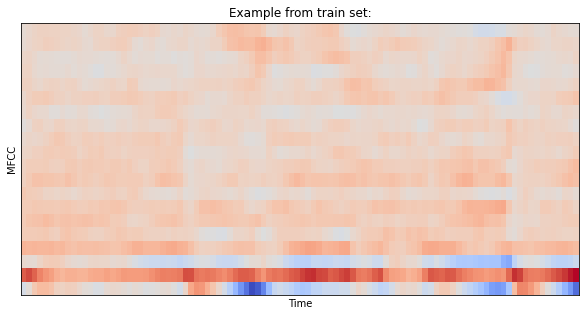

In [ ]:
X_trainExample = X_train[0,:, :, 0]
X_trainExample = X_trainExample.T

plt.figure(figsize=(10,5))
librosa.display.specshow(X_trainExample, sr=sampleRate, hop_length=hopLength)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.title("Example from train set:")

In [ ]:
model = models.Sequential()

#Layer 1
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2) , padding = 'same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dropout(.4))

#Layer 2
model.add(Convolution2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides = (2,2) , padding = 'same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dropout(.4))

#Layer 3
model.add(Convolution2D(128, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2) , padding = 'same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dropout(.5))

model.add(Flatten())
model.add(keras.layers.Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation = 'softmax'))



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 18, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 9, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 49, 9, 32)        128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 49, 9, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 7, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 4, 64)        0

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

history = model.fit(X_train, y_train, epochs=64, 
                    validation_data=(X_validation, y_validation),callbacks= [EarlyStopping(monitor='val_accuracy', patience=15)])

Epoch 1/64


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


244/244 [==============================] - 30s 117ms/step - loss: 1.9193 - accuracy: 0.3359 - val_loss: 1.7402 - val_accuracy: 0.3762
Epoch 2/64
244/244 [==============================] - 32s 130ms/step - loss: 1.4474 - accuracy: 0.4636 - val_loss: 1.6636 - val_accuracy: 0.4088
Epoch 3/64
244/244 [==============================] - 29s 117ms/step - loss: 1.3171 - accuracy: 0.5096 - val_loss: 1.5886 - val_accuracy: 0.4315
Epoch 4/64
244/244 [==============================] - 28s 115ms/step - loss: 1.2213 - accuracy: 0.5463 - val_loss: 1.6047 - val_accuracy: 0.4854
Epoch 5/64
244/244 [==============================] - 28s 114ms/step - loss: 1.1655 - accuracy: 0.5625 - val_loss: 1.5917 - val_accuracy: 0.4712
Epoch 6/64
244/244 [==============================] - 28s 115ms/step - loss: 1.1193 - accuracy: 0.5862 - val_loss: 1.4557 - val_accuracy: 0.4808
Epoch 7/64
244/244 [==============================] - 30s 123ms/step - loss: 1.0751 - accuracy: 0.6144 - val_loss: 1.4820 - val_accuracy: 0.5

Plot the model:

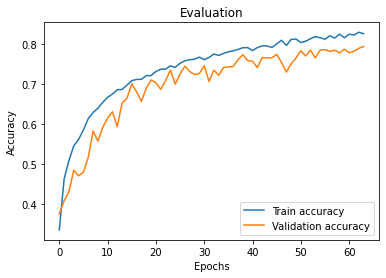

In [ ]:
# Plot the model's test and train accuracy
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Evaluation")
plt.legend(loc="lower right")

plt.show()

Test acccuracy:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

82/82 [==============================] - 2s 26ms/step - loss: 0.6359 - accuracy: 0.7877
Test accuracy: 0.7876923084259033


Validation Accuracy

In [ ]:
validation_loss, validation_acc = model.evaluate(X_validation, y_validation)
print('Validation accuracy:', validation_acc)

82/82 [==============================] - 4s 44ms/step - loss: 0.6550 - accuracy: 0.7950
Validation accuracy: 0.7950000166893005


Predict a song that's outside the set.
Pick a segment from a song.

In [51]:
# Multiple audio files pre-processing

# Librosa warnings are printed although nothing is wrong with the code,
# https://github.com/librosa/librosa/issues/1015.
import sys
import warnings
warnings.filterwarnings('ignore')


#audio_path = "/content/drive/MyDrive/BossaAntiguaPrediction.mp3"
#audio_path = "/content/drive/MyDrive/Scott_Fields_Santa_on_a_Segway.mp3"
#audio_path = "/content/drive/MyDrive/Bryan_Mathys_Wild_Heart.mp3"
audio_path = "/content/drive/MyDrive/mp3tests"

prediction_array = np.array([])
previousGenreNum = 0
accuracy = 0

# Go through genre files
for subdir, dirs, files in os.walk(audio_path):

  # Going through all the audio files in each folder (10 of each genre)
  for file in files:
    
    # Get the genre name from current folder.
    currentGenre = subdir.split("/")[-1]
    currentGenreNum = genreToNum[currentGenre]
    
    # Load audio file using librosa.
    currentFile = os.path.join(subdir, file)
    currentAudio,sampleRate = librosa.load(currentFile, sr=sampleRate)
    XasList = []

    # Go through one audio file
    for i in range(segments):
          # Print which audio file is currently being worked on.
          # printMessage = f'Working on: {currentFile.split("/")[6]} Segment {i}'
          # print(printMessage)

          # Calculate the start and finish points of segments.
          start = samplePerSeg * i
          finish = start + samplePerSeg

          # Calculate mfcc of audio segment.
          mfcc = librosa.feature.mfcc(currentAudio[start:finish], sampleRate, n_mfcc=numMFCC, n_fft=nFFT, hop_length=hopLength)
          mfcc = mfcc.T

          # Add MFCC to data only if the mfcc vector length are good
          
          if mfcc.shape[0] == mfccPerSeg:
            XasList.append(mfcc.tolist())
              
    # Convert python list to numpy array
    X = np.array(XasList)
    Xprediction = X[8]
    Xprediction = Xprediction[np.newaxis, ..., np.newaxis]
    prediction = model.predict(Xprediction)
    predicted_index = np.argmax(prediction, axis=1)

    # We are testing to see if we are in a new genre, if we are then calculate the accuracy
    if (previousGenreNum == currentGenreNum):
      if predicted_index[0] == currentGenreNum:
        accuracy += 1
    else:
      accuracy = accuracy / 10
      prediction_array = np.append(prediction_array, accuracy)
      accuracy = 0

    previousGenreNum = currentGenreNum

    # print(printMessage)
    print("Predicted genre's number:", predicted_index)

accuracy = accuracy / 10
prediction_array = np.append(prediction_array, accuracy)
print(prediction_array)

1/1 [==============================] - 0s 36ms/step
Predicted genre's number: [2]
1/1 [==============================] - 0s 25ms/step
Predicted genre's number: [2]
1/1 [==============================] - 0s 25ms/step
Predicted genre's number: [2]
1/1 [==============================] - 0s 26ms/step
Predicted genre's number: [4]
1/1 [==============================] - 0s 27ms/step
Predicted genre's number: [9]
1/1 [==============================] - 0s 34ms/step
Predicted genre's number: [0]
1/1 [==============================] - 0s 30ms/step
Predicted genre's number: [9]
1/1 [==============================] - 0s 27ms/step
Predicted genre's number: [2]
1/1 [==============================] - 0s 34ms/step
Predicted genre's number: [8]
1/1 [==============================] - 0s 29ms/step
Predicted genre's number: [9]
1/1 [==============================] - 0s 30ms/step
Predicted genre's number: [5]
1/1 [==============================] - 0s 31ms/step
Predicted genre's number: [1]
1/1 [===========

genreToNum = {
      "blues":0,
      "classical":1,
      "country":2,
      "disco":3,
      "hiphop":4,
      "jazz" :5,
      "metal" :6,
      "pop" :7,
      "reggae" :8,
      "rock" :9
  }

In [ ]:
# Single Audio File Pre-processing

audio_path = "/content/drive/MyDrive/mp3tests/jazz/BossaAntiguaPrediction.mp3"
# audio_path = "/content/drive/MyDrive/mp3tests/jazz/Scott Fields - Santa on a Segway"
#audio_path = "/content/drive/MyDrive/Bryan_Mathys_Wild_Heart.mp3"
#audio_path = "/content/drive/MyDrive/IMLC_Messiah_for_Hire.mp3"

currentAudio,sampleRate = librosa.load(audio_path, sr=sampleRate)
XasList = []

  # Go through one audio file
for i in range(segments):

      # Print which audio file is currently being worked on.
              printMessage = f'Working on: {audio_path.split("/")[6]} Segment {i}'
              print(printMessage)

              # Calculate the start and finish points of segments.
              start = samplePerSeg * i
              finish = start + samplePerSeg

              # Calculate mfcc of audio segment.
              mfcc = librosa.feature.mfcc(currentAudio[start:finish], sampleRate, n_mfcc=numMFCC, n_fft=nFFT, hop_length=hopLength)
              mfcc = mfcc.T

              # Add MFCC to data only if the mfcc vector length are good
              
              if mfcc.shape[0] == mfccPerSeg:
                XasList.append(mfcc.tolist())
          
  # Convert python list to numpy array
X = np.array(XasList)




Xprediction = X[8]
Xprediction = Xprediction[np.newaxis, ..., np.newaxis]
prediction = model.predict(Xprediction)
predicted_index = np.argmax(prediction, axis=1)
print(printMessage)
print("Predicted genre's number:", predicted_index)